In [48]:
import requests
import pandas as pd
import warnings
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from lightgbm import LGBMClassifier, plot_importance, log_evaluation
from sklearn.preprocessing import MinMaxScaler
from colorama import Fore, Back, Style
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, GridSearchCV
from scipy.stats import rankdata
import datetime
import gc
import time
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Data

In [3]:
df_reference = pd.read_csv("../input/frcml/Scouting Qualification Matches - All Teams.csv")
df_reference = df_reference.rename(columns={' ':'TEAM_KEY'})
df_reference = df_reference.set_index("TEAM_KEY")
df_reference.drop(["T24 AVG", "OVR AVG"], axis=0, inplace=True)
df_reference["HAS_CLIMB"] = (~(df_reference["CLIMB-PTS"] == 0)).astype("int")

In [4]:
features = [x for x in df_reference.columns if x not in ["POWER RATING"]]

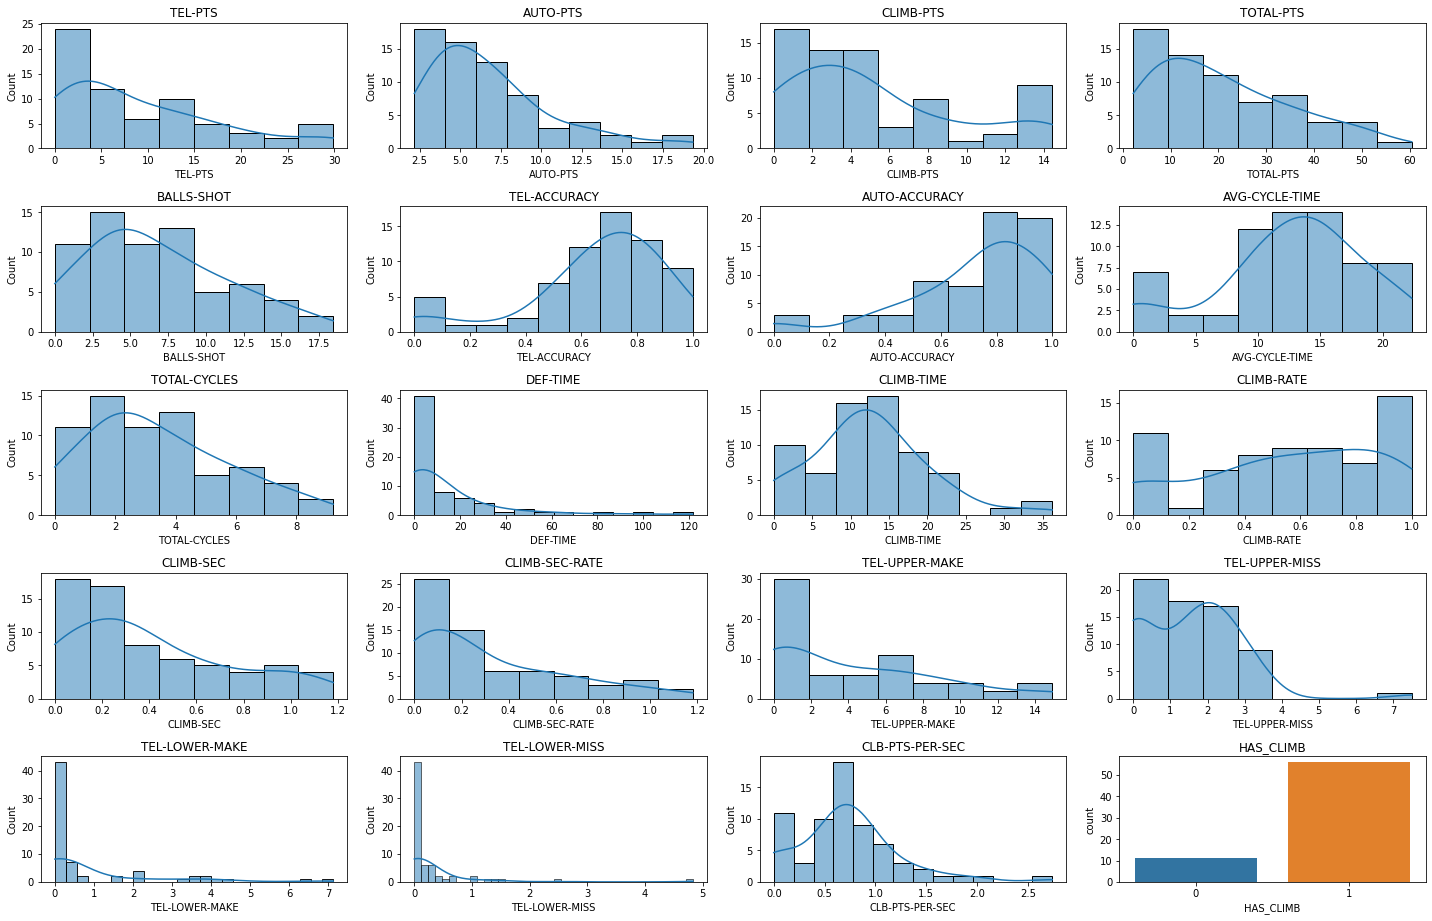

In [5]:
fig = plt.figure(figsize=(20, 15))
for i, x in enumerate(features):
    ax = fig.add_subplot(6, 4, i + 1)
    if df_reference[x].dtypes == "float64":
        sns.histplot(data=df_reference, x=x, kde=1, ax=ax).set_title(x)
    else:
        sns.countplot(data=df_reference, x=x, ax=ax).set_title(x)

fig.tight_layout()
plt.show()

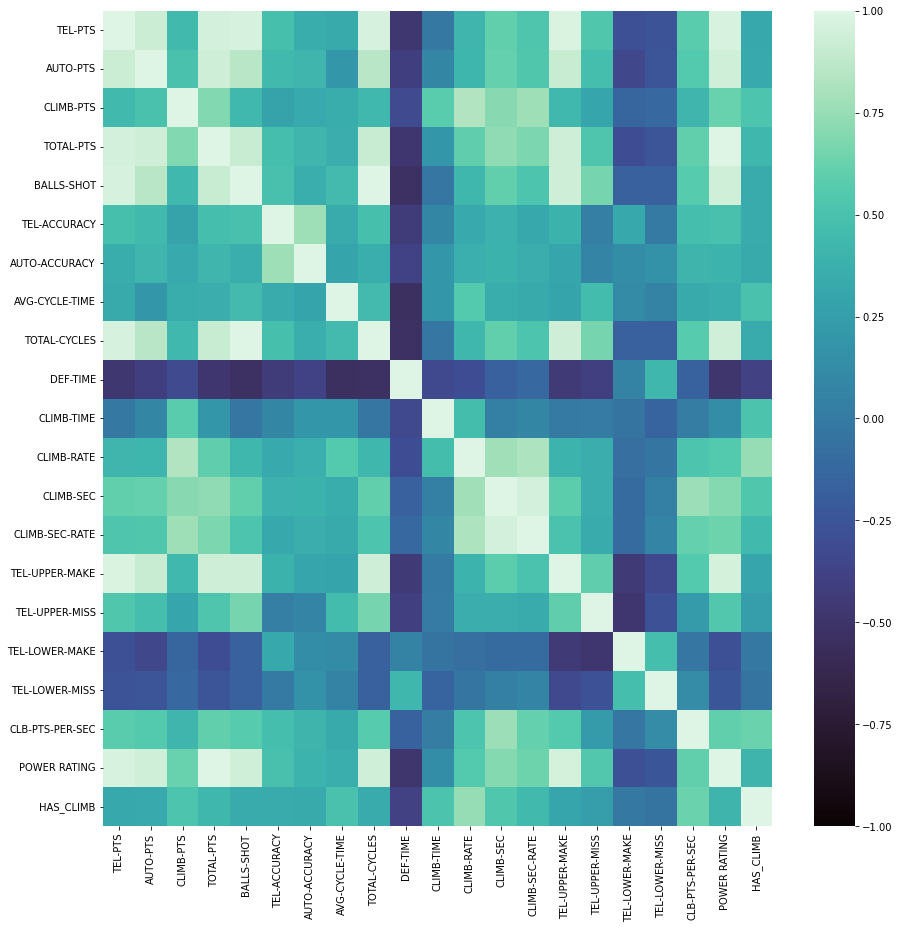

In [6]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_reference.corr(), cmap='mako', vmin=-1)
plt.show()

## API

In [7]:
df_train = pd.DataFrame()

In [8]:
key = 'monpiIlPoQ81Y5bc8zhoMNuTbm8bLHQzYikSQuYYZHvM3BbAm8Y4uFeaOU6bMNg1'
events = ["2022oncmp", "2022on305", "2022on306", "2022on325", "2022on326", "2022on263", "2022on273", "2022on204", "2022on034", "2022on409", "2022on410"]

In [9]:
match_id = 0
for event in events:
    response = requests.get(f'https://www.thebluealliance.com/api/v3/event/{event}/matches', headers={"X-TBA-Auth-Key":key})
    print(f'loaded {len(response.json())} matches from {event}')

    matches = response.json()

#     blue_win = 0
#     red_win = 0
#     for match in matches:
#         if match['winning_alliance'] == 'blue':
#             blue_win += 1
#         else:
#             red_win += 1
#     plt.pie([blue_win, red_win], labels=["blue", "red"])
#     plt.show()

    for match in matches:
        blue_alliance = match['alliances']['blue']['team_keys']
        red_alliance = match['alliances']['red']['team_keys']
        df_train = df_train.append(pd.Series([match_id, blue_alliance[0], blue_alliance[1], blue_alliance[2], red_alliance[0], red_alliance[1], red_alliance[2], match["winning_alliance"]]), ignore_index=True)
        match_id += 1

loaded 150 matches from 2022oncmp
loaded 30 matches from 2022on305
loaded 32 matches from 2022on306
loaded 34 matches from 2022on325
loaded 34 matches from 2022on326
loaded 34 matches from 2022on263
loaded 35 matches from 2022on273
loaded 30 matches from 2022on204
loaded 27 matches from 2022on034
loaded 30 matches from 2022on409
loaded 33 matches from 2022on410


In [10]:
df_train.head()

,0,1,2,3,4,5,6,7
0,0.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,blue
1,1.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,red
2,2.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,red
3,3.0,frc4976,frc4946,frc4917,frc1114,frc2056,frc4152,red
4,4.0,frc4976,frc4946,frc4917,frc1114,frc2056,frc4152,red


## Training Data

In [11]:
df_train.columns=["match_id", "blue_1", "blue_2", "blue_3", "red_1", "red_2", "red_3", "win"]
df_train["match_id"] = df_train["match_id"].astype("float")
df_train = df_train.set_index("match_id")
df_train["win"] = (~(df_train["win"]=="blue")).astype('float')

In [12]:
df_train.head()

,blue_1,blue_2,blue_3,red_1,red_2,red_3,win
match_id,,,,,,,
0.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,0.0
1.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,1.0
2.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,1.0
3.0,frc4976,frc4946,frc4917,frc1114,frc2056,frc4152,1.0
4.0,frc4976,frc4946,frc4917,frc1114,frc2056,frc4152,1.0


In [13]:
df_train.shape

(469, 7)

In [14]:
def expand_team_data(df, match_id):
    if any(df.loc[match_id, team_pos].replace("frc", "") not in df_reference.index for team_pos in ["blue_1", "blue_2", "blue_3", "red_1", "red_2", "red_3"]):
        return df
    for feature in features:
        df.loc[match_id, f'delta_{feature}'] = df_reference.loc[df.loc[match_id, "blue_1"].replace("frc", ""), feature] + df_reference.loc[df.loc[match_id, "blue_2"].replace("frc", ""), feature] + df_reference.loc[df.loc[match_id, "blue_3"].replace("frc", ""), feature] - (df_reference.loc[df.loc[match_id, "red_1"].replace("frc", ""), feature] + df_reference.loc[df.loc[match_id, "red_2"].replace("frc", ""), feature] + df_reference.loc[df.loc[match_id, "red_3"].replace("frc", ""), feature])
#         df.loc[match_id, f'blue_{feature}'] = df_reference.loc[df.loc[match_id, "blue_1"].replace("frc", ""), feature] + df_reference.loc[df.loc[match_id, "blue_2"].replace("frc", ""), feature] + df_reference.loc[df.loc[match_id, "blue_3"].replace("frc", ""), feature]
#         df.loc[match_id, f'red_{feature}'] = df_reference.loc[df.loc[match_id, "red_1"].replace("frc", ""), feature] + df_reference.loc[df.loc[match_id, "red_2"].replace("frc", ""), feature] + df_reference.loc[df.loc[match_id, "red_3"].replace("frc", ""), feature]

#         df.loc[match_id, f"blue_1_{feature}"] = df_reference.loc[df.loc[match_id, "blue_1"].replace("frc", ""), feature]
#         df.loc[match_id, f"blue_2_{feature}"] = df_reference.loc[df.loc[match_id, "blue_2"].replace("frc", ""), feature]    
#         df.loc[match_id, f"blue_3_{feature}"] = df_reference.loc[df.loc[match_id, "blue_3"].replace("frc", ""), feature]    
#         df.loc[match_id, f"red_1_{feature}"] = df_reference.loc[df.loc[match_id, "red_1"].replace("frc", ""), feature]    
#         df.loc[match_id, f"red_2_{feature}"] = df_reference.loc[df.loc[match_id, "red_2"].replace("frc", ""), feature]    
#         df.loc[match_id, f"red_3_{feature}"] = df_reference.loc[df.loc[match_id, "red_3"].replace("frc", ""), feature]
    return df

In [15]:
for i in range(len(df_train)):
    df_train = expand_team_data(df_train, i)

In [16]:
df_train = df_train.dropna()
df_train = df_train.reset_index()

In [17]:
df_train.head()

,match_id,blue_1,blue_2,blue_3,red_1,red_2,red_3,win,delta_TEL-PTS,delta_AUTO-PTS,...,delta_CLIMB-TIME,delta_CLIMB-RATE,delta_CLIMB-SEC,delta_CLIMB-SEC-RATE,delta_TEL-UPPER-MAKE,delta_TEL-UPPER-MISS,delta_TEL-LOWER-MAKE,delta_TEL-LOWER-MISS,delta_CLB-PTS-PER-SEC,delta_HAS_CLIMB
0,0.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,0.0,-1.86,-3.20,...,-20.67,0.12,0.30,0.26,-3.76,1.81,0.15,0.00,0.46,0.0
1,1.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,1.0,-1.86,-3.20,...,-20.67,0.12,0.30,0.26,-3.76,1.81,0.15,0.00,0.46,0.0
2,2.0,frc3683,frc4678,frc610,frc1114,frc2056,frc4152,1.0,-1.86,-3.20,...,-20.67,0.12,0.30,0.26,-3.76,1.81,0.15,0.00,0.46,0.0
3,3.0,frc4976,frc4946,frc4917,frc1114,frc2056,frc4152,1.0,-24.49,-11.66,...,7.12,-0.11,-0.22,-0.15,-12.46,4.41,0.42,0.61,-0.14,0.0
4,4.0,frc4976,frc4946,frc4917,frc1114,frc2056,frc4152,1.0,-24.49,-11.66,...,7.12,-0.11,-0.22,-0.15,-12.46,4.41,0.42,0.61,-0.14,0.0


In [18]:
num_features = [x for x in df_train.columns if x not in ["match_id", "blue_1", "blue_2", "blue_3", "red_1", "red_2", "red_3", "win", "delta-HAS-CLIMB"]]

In [19]:
MMSCALER = MinMaxScaler()
df_train[num_features] = MMSCALER.fit_transform(df_train[num_features])

In [20]:
df_train.shape

(333, 28)

In [21]:
features_feed = [x for x in df_train.columns if x not in ["match_id", "blue_1", "blue_2", "blue_3", "red_1", "red_2", "red_3", "win"]]

<AxesSubplot:xlabel='win', ylabel='count'>

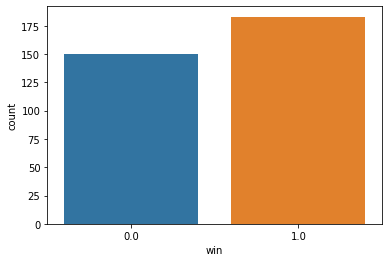

In [22]:
sns.countplot(data=df_train, x="win")

<AxesSubplot:>

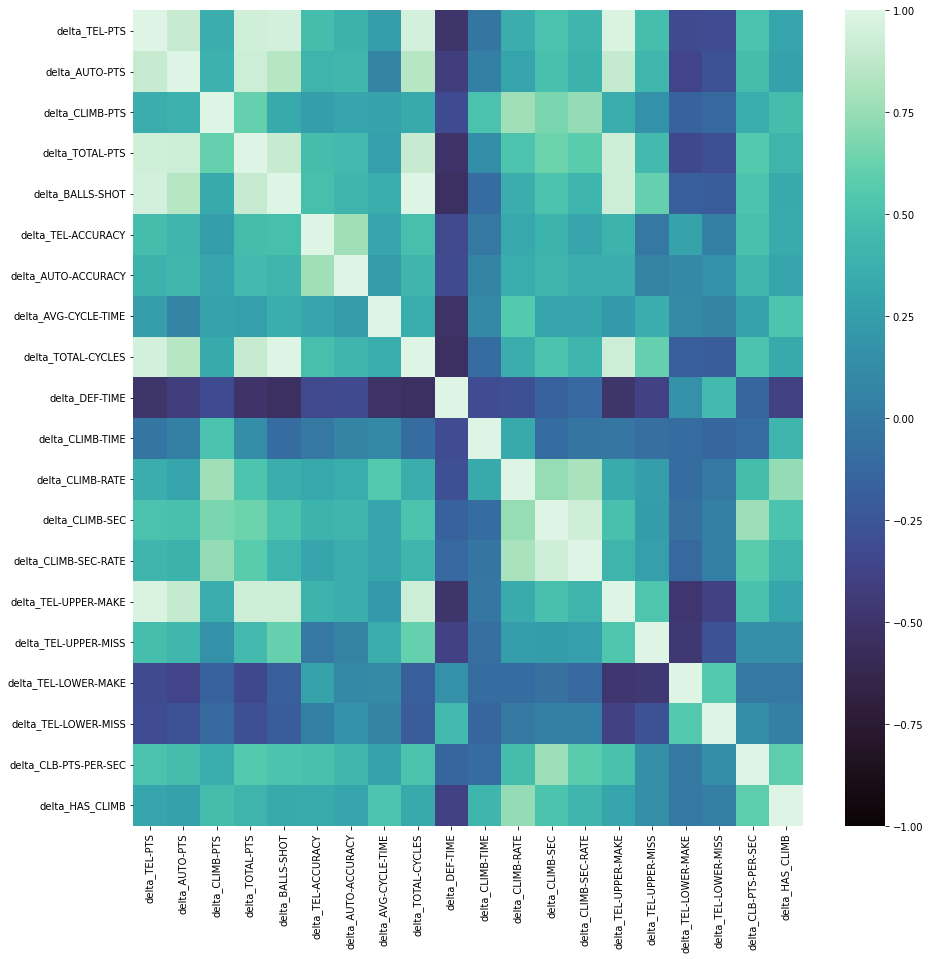

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train[features_feed].corr(), cmap='mako', vmin=-1, vmax=1)

## ML

In [24]:
classifiers = {
    "LGBM" : LGBMClassifier(random_state=0),
    "SVC" : SVC(random_state=0, probability=True),
    "RF" : RandomForestClassifier(random_state=0),
    "NB" : GaussianNB(),
    "DT" : DecisionTreeClassifier(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "CAT" : CatBoostClassifier(random_state=0, verbose=0),
    "XGB" : XGBClassifier(random_state=0)
}

grid_BOOST = {'n_estimators': [15, 30, 45],'max_depth': [3, 4, 5],'learning_rate': [0.04, 0.06, 0.08],}
grid_DT = {'criterion': ['gini', 'entropy'],'max_depth': [1, 2, 4,]}
grid_RF = {'n_estimators': [50, 100, 150, 200, 250, 300],'max_depth': [4, 6, 8, 10, 12]}
grid_KNN = {'n_neighbors': [6, 7, 8],'p': [1, 2]}
grid_SVC = {'C': [1.75, 2, 2.25],'kernel': ['linear', 'rbf'],'gamma': ['scale', 'auto']}
grid_NB = {'var_smoothing': [1e-12, 1e-11, 1e-10]}

grids = {
    "LGBM_grid": grid_BOOST,
    "CAT_grid": grid_BOOST,
    "XGB_grid": grid_BOOST,
    "SVC_grid": grid_SVC,
    "RF_grid" : grid_RF,
    "NB_grid" : grid_NB,
    "DT_grid" : grid_DT,
    "KNN_grid" : grid_KNN
}

clf_best_params = {"LGBM" : None, "SVC" : None, "RF" : None, "NB" : None, "DT" : None, "KNN" : None, "XGB" : None, "CAT" : None}


models = pd.DataFrame({'Classifier' : classifiers.keys(), 'score' : np.zeros(len(classifiers.keys()))})
models = models.set_index('Classifier')

In [25]:
for name, model in classifiers.items():
    print("------------")
    print(name)
    start = time.time()
    grid = grids[f'{name}_grid']
    clf = None
    clf = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, verbose=0, scoring="roc_auc")
    clf.fit(df_train[features_feed],  df_train["win"])
    clf_best_params[name] = clf.best_params_
    print(clf.best_params_)

------------
LGBM
{'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 30}
------------
SVC
{'C': 2.25, 'gamma': 'auto', 'kernel': 'rbf'}
------------
RF
{'max_depth': 4, 'n_estimators': 250}
------------
NB
{'var_smoothing': 1e-12}
------------
DT
{'criterion': 'entropy', 'max_depth': 2}
------------
KNN
{'n_neighbors': 8, 'p': 2}
------------
CAT
{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 45}
------------
XGB
{'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 45}


In [26]:
classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "SVC" : SVC(**clf_best_params["SVC"], random_state=0, probability=True),
    "RF" : RandomForestClassifier(**clf_best_params["RF"], random_state=0),
    "NB" : GaussianNB(**clf_best_params["NB"]),
    "DT" : DecisionTreeClassifier(**clf_best_params["DT"], random_state=0),
    "KNN" : KNeighborsClassifier(**clf_best_params["KNN"]),
    "CAT" : CatBoostClassifier(**clf_best_params["CAT"], random_state=0, verbose=0),
    "XGB" : XGBClassifier(**clf_best_params["XGB"], random_state=0),
}

In [27]:
for name, clf in classifiers.items():
    scores = cross_val_score(clf, df_train[features_feed], df_train["win"], scoring="roc_auc")
    print(f"Score: {name}:", scores)
    models.loc[name, "score"] = np.mean(scores)

Score: LGBM: [0.8981982  0.84954955 0.89144144 0.88611111 0.90462963]
Score: SVC: [0.9036036  0.88018018 0.94954955 0.88518519 0.93425926]
Score: RF: [0.8990991  0.87477477 0.90630631 0.86203704 0.9037037 ]
Score: NB: [0.86486486 0.86756757 0.8963964  0.85462963 0.91759259]
Score: DT: [0.85135135 0.87702703 0.86171171 0.87638889 0.89861111]
Score: KNN: [0.83873874 0.88693694 0.82927928 0.82037037 0.87592593]
Score: CAT: [0.89189189 0.88648649 0.92612613 0.86481481 0.91481481]
Score: XGB: [0.9        0.84234234 0.9036036  0.86481481 0.8962963 ]


In [28]:
models.sort_values(by='score', ascending=0)
models["weight"] = rankdata(models['score'])
models

,score,weight
Classifier,,
LGBM,0.885986,5.0
SVC,0.910556,8.0
RF,0.889184,6.0
NB,0.880210,3.0
DT,0.873018,2.0
KNN,0.850250,1.0
CAT,0.896827,7.0
XGB,0.881411,4.0


## Ensemble

fold_0 score: 0.9010889292196007
fold_1 score: 0.823956442831216
fold_2 score: 0.8019047619047619
fold_3 score: 0.8634259259259258
fold_4 score: 0.8558884297520661
avg roc auc score: 0.849252897926714


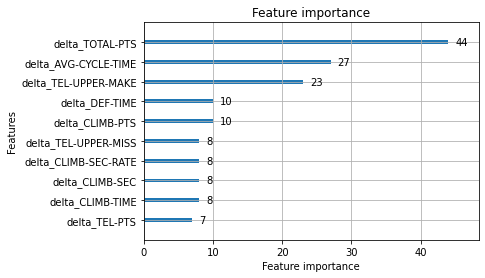

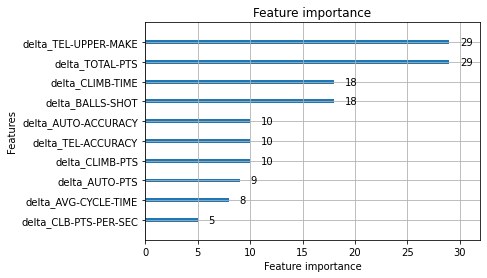

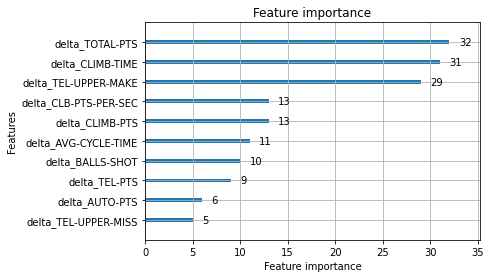

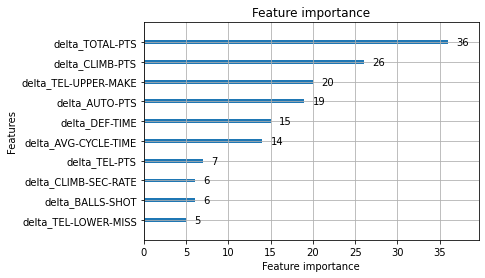

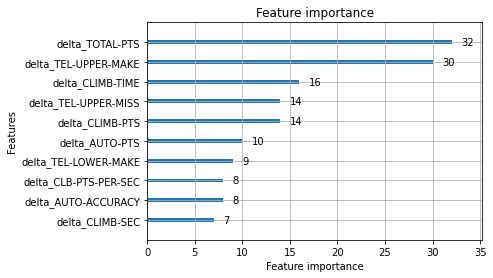

In [29]:
roc_auc_scores = []
kf = KFold(n_splits=5)
for idx, (train_idx, test_idx) in enumerate(kf.split(df_train[features_feed], df_train["win"])):
    X_train, X_test = df_train[features_feed].iloc[train_idx], df_train[features_feed].iloc[test_idx]
    y_train, y_test = df_train["win"][train_idx], df_train["win"][test_idx]

    preds=np.zeros(len(X_test))
    
    for model_name in models.index:
        clf = classifiers[model_name]
        clf.fit(X_train, y_train)
        preds += clf.predict(X_test) * models.loc[model_name, 'weight']
        
        if model_name == 'LGBM':
            plot_importance(clf,max_num_features=10)
        
    preds /= np.sum(models.weight)
    
    fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label = 1)
    score = auc(fpr, tpr)
    roc_auc_scores.append(score)
    print(f"fold_{idx} score: {score}")

print(f"avg roc auc score: {np.mean(roc_auc_scores)}")

## Inference - Data from 2022 CNE

In [67]:
event = "2022oncne"

response = requests.get(f'https://www.thebluealliance.com/api/v3/event/{event}/matches', headers={"X-TBA-Auth-Key":key})
print(f'loaded {len(response.json())} matches from {event}')

matches = response.json()

df_test = pd.DataFrame()
ground_truth = list()

for match in matches:
    blue_alliance = match['alliances']['blue']['team_keys']
    red_alliance = match['alliances']['red']['team_keys']
    df_test = df_test.append(pd.Series([blue_alliance[0], blue_alliance[1], blue_alliance[2], red_alliance[0], red_alliance[1], red_alliance[2]]), ignore_index=True)
    ground_truth.append(int(match["winning_alliance"]=="red"))
    
ground_truth = pd.Series(ground_truth)
df_test.columns=["blue_1", "blue_2", "blue_3", "red_1", "red_2", "red_3"]
for x in range(len(df_test)):
    df_test = expand_team_data(df_test, x)
df_test[num_features] = MMSCALER.transform(df_test[num_features])

loaded 30 matches from 2022on305


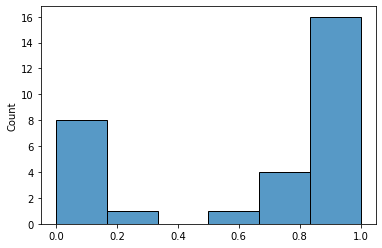

[1.  1.  1.  1.  0.5 0.  0.8 1.  1.  0.  0.  0.2 1.  0.  0.  1.  0.  0.8
 0.9 0.8 0.8 0.9 1.  0.  0.1 1.  1.  1.  1.  1. ]
score: 0.8666666666666667


In [82]:
preds = np.zeros(len(df_test))

# weights = None
# using_models = None
weights = [4, 3, 2, 1]
using_models = ["SVC", "RF", "LGBM", "NB"]

for i, model_name in enumerate(using_models if using_models != None else models.index):
    clf = classifiers[model_name]
    clf.fit(df_train[features_feed], df_train["win"])
    preds += clf.predict(df_test[features_feed]) * models.loc[model_name, 'weight'] if weights == None else clf.predict(df_test[features_feed]) * weights[i]
preds /= np.sum(models.weight) if weights == None else np.sum(weights)

sns.histplot(preds, binrange=(0, 1))
plt.show()

print(preds)

score = accuracy_score(np.rint(preds), ground_truth)
print(f"score: {score}")

In [41]:
df_test = pd.DataFrame()

df_test = df_test.append(pd.Series(["1",  "771", "772", "1334", "1114", "2056", "1241"]), ignore_index=True)
df_test = df_test.append(pd.Series(["1", "610", "2056", "1241", "771", "772", "1334"]), ignore_index=True)
df_test.columns=["blue_1", "blue_2", "blue_3", "red_1", "red_2", "red_3"]
df_test = expand_team_data(df_test, 0)
df_test = expand_team_data(df_test, 1)

df_test[num_features] = MMSCALER.transform(df_test[num_features])

In [42]:
preds = np.zeros(len(df_test))
for model_name in models.index:
    clf = classifiers[model_name]
    clf.fit(df_train[features_feed], df_train["win"])
    preds +=clf.predict(df_test[features_feed]) * models.loc[model_name, 'weight']
preds /= np.sum(models.weight)
print(preds)

[1. 0.]
